# Import the Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.subplots as sp
import numpy as np
from scipy.optimize import minimize
from DP_Binary import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from DQN_Binary_split.PortfolioRebalancerEnv_Roy import PortfolioRebalancerEnv

import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px

from sklearn.metrics import confusion_matrix
sns.set_theme()

In [2]:
plt.rcParams.update({"font.size": 18})
tmp_device = torch.device("cpu")

In [3]:
og_path = os.getcwd()
og_path

'/Users/Roy/Desktop/College/GeorgiaTech/Research/Portfolio-Rebalancing-DQN'

# Initialize

In [4]:
n_asset = 2

In [5]:
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [6]:
# tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]
tc_list = [0, 0.0001, 0.0002, 0.0003,
           0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

In [7]:
x = np.arange(1, 101)
state_possible = np.array(np.meshgrid(*([x] * n_asset))).T.reshape(-1, n_asset).astype(np.float32)
state_possible = state_possible[state_possible.sum(axis=1) == 100, :] / 100

In [8]:
#######################################################################################################################
# Define Necessary Functions
#######################################################################################################################


# Net Sharpe Ratio
def net_sharpe(w1, mu, cov):
    """

    :param w1: next state
    :param mu: mean
    :param cov: covariance diagonal matrix
    :param w0: current state
    :param tc: transaction costs
    :return: net sharpe value
    """
    return (w1.dot(mu)) / np.sqrt(w1.dot(cov).dot(w1))


# Objective Function
def obj_func(x, mu, cov):
    """
    Objective Function for the Mean Variance optimization algorithm.
    :param x: tmp weight
    :param mu: mean
    :param cov: covariance diagonal matrix
    :return:
    """
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


# Finding Optimal Weight given mean and covariance
def find_optimal_wgt(mu, cov):
    # TODO: Should we change w_max to 1 or to 2/n ? so if n = 8 limit would be 0.25 in one asset?
    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=constraints,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param tc: transaction costs
    :return: cost turnover value
    """
    return np.sum(np.abs(w1 - w0) * tc)


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param opt_w: optimal mean-variance weights
    :param mu: mean of returns
    :param cov: covariance of returns
    :param tc: transaction costs
    :return: expected cost of optimal - state net sharpe values
    """
    opt_net_sharpe = net_sharpe(w1=opt_w, mu=mu, cov=cov, w0=w0, tc=tc)
    w1_net_sharpe = net_sharpe(w1=w1, mu=mu, cov=cov, w0=w0, tc=tc)
    return opt_net_sharpe - w1_net_sharpe


# DP Binary

In [9]:
dp_path = og_path + '/DP_Binary_split/results/models/'
os.chdir(dp_path)

In [10]:
df_list = []
for tc in tc_list:
    tmp_df = pd.read_csv(f"dp_tc_{tc}_assets_2", index_col=0, dtype=np.float32)
    df_list.append(tmp_df)

In [11]:
state_possible = pd.to_numeric(tmp_df.index.values)
action_possible = pd.to_numeric(tmp_df.columns.values)

In [12]:
action_df = pd.DataFrame(index=state_possible)
action_bm_df = pd.DataFrame(index=state_possible)
for tc, bell in zip(tc_list, df_list):
    action = pd.to_numeric(bell.idxmax(axis=1)).values
    action_df[f"TC: {tc * 1e4:.0f} bps"] = action

In [13]:
optimal_weight = find_optimal_wgt(mu, cov).round(2)
optimal_weight

array([0.64, 0.36])

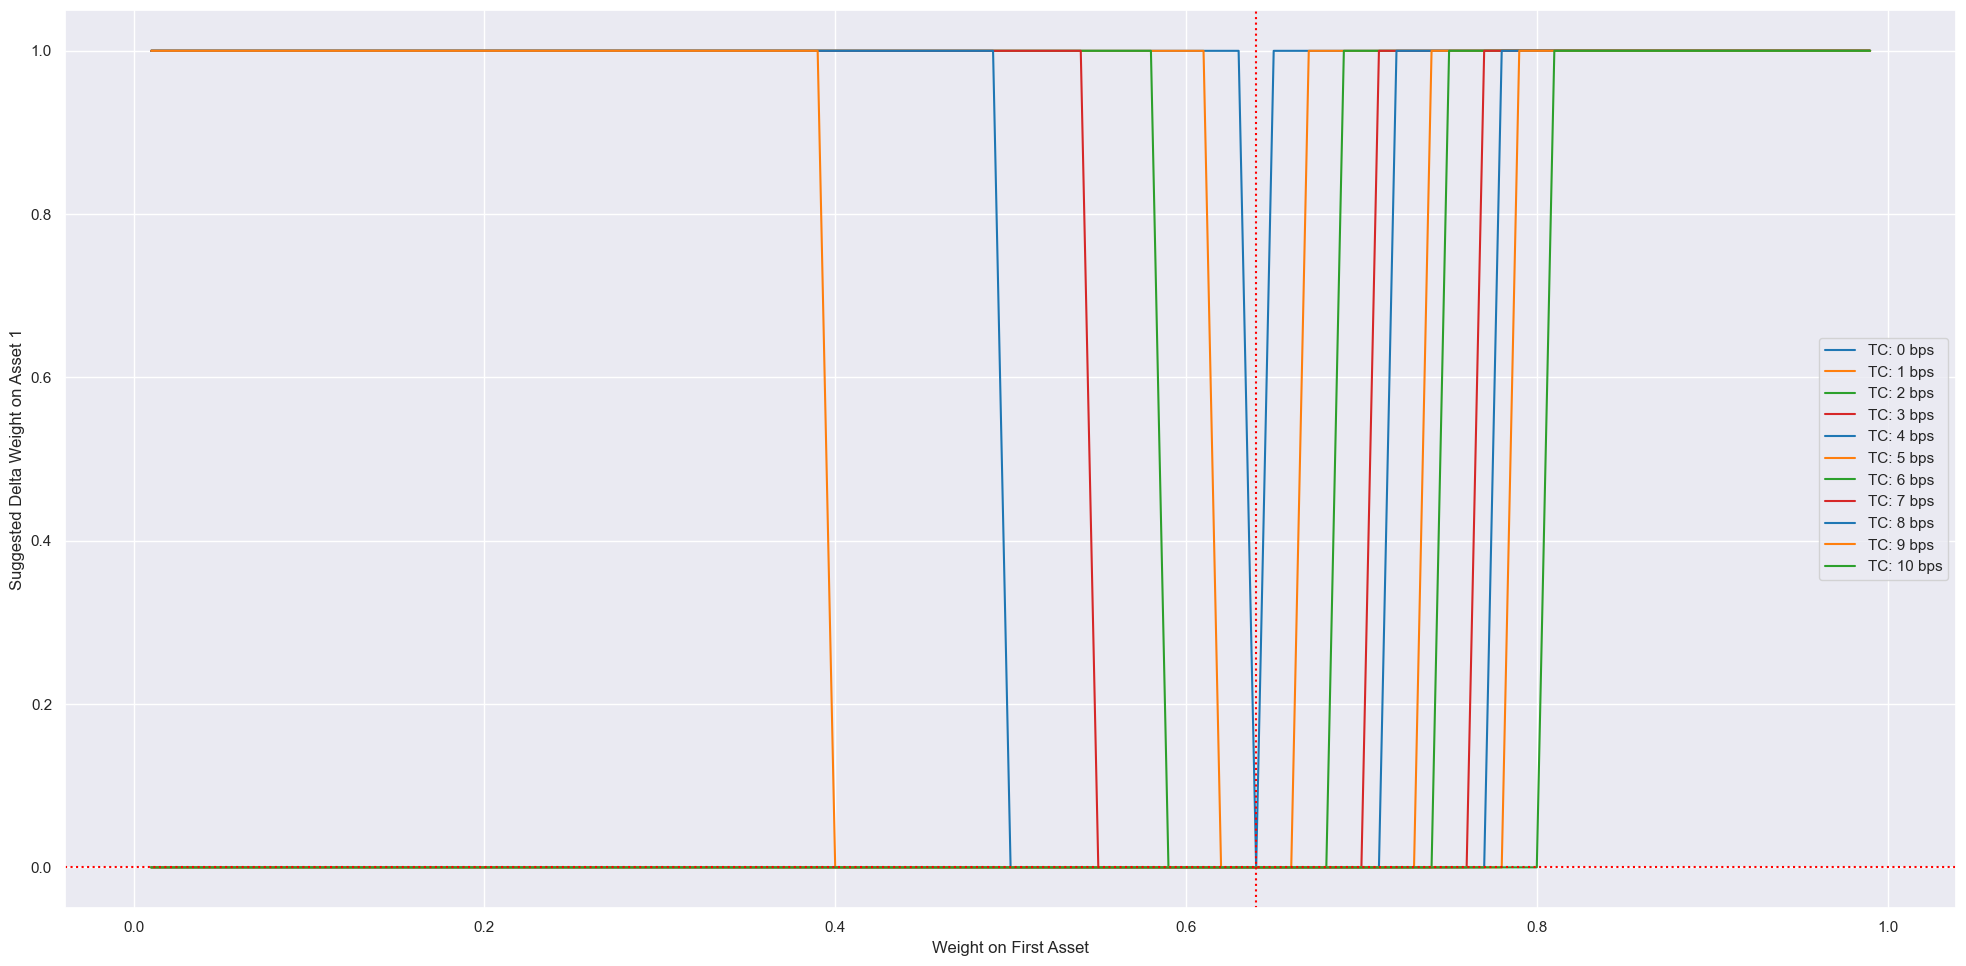

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()


<Axes: >

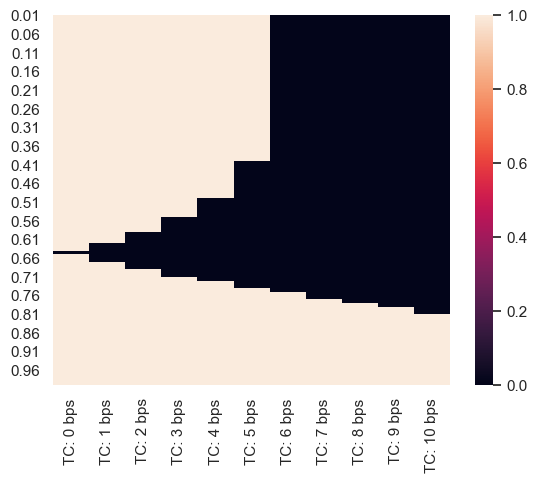

In [15]:
import seaborn as sns
sns.heatmap(action_df)

In [16]:
# Create a heatmap trace for DP Bellman
trace_dp = go.Heatmap(z=action_df, x=action_df.columns, y=action_df.index, name="DP Binary Bellman")

# Create the layout with 'overlay' parameter set to "overlay"
layout = go.Layout(
    title="DP Binary Bellman Output",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Weight on First Asset",
               showgrid=True),
    # barmode="overlay"  # Set the barmode to overlay
)

# Add horizontal line at y=0.50
layout.shapes = [
    dict(
        type="line",
        x0=action_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=action_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=0.5),  # You can customize the color and width of the line
    )
]

# Create the figure
fig = go.Figure(data=[trace_dp], layout=layout)
fig.show()

# DQN Binary

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions, name, tc, chkpt_dir='results/models'):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

        self.checkpoint_file = os.path.join(chkpt_dir, name + f'_tc_{tc}_assets_{n_observations}_dqn')

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [18]:
def save_models(pn, tn):
    pn.save_checkpoint()
    tn.save_checkpoint()

def load_models(pn, tn):
    pn.load_checkpoint()
    tn.load_checkpoint()

In [19]:
ddpg_path = og_path + '/DQN_Binary_split/'
os.chdir(ddpg_path)

In [20]:
optimal_weight = find_optimal_wgt(mu, cov).round(2)
optimal_weight

array([0.64, 0.36])

In [21]:
# RL:
BATCH_SIZE = 1024
GAMMA = 0.99
EPS_START = 0.999
EPS_END = 0.05
EPS_DECAY = 1_000
TAU = 0.005
LR = 1e-4
MEMORY_SIZE = 10_000

n_manager = 2
mu = np.array([50, 200]) / 1e4
sigma = np.array([300, 800]) / 1e4
cov = np.diag(sigma ** 2)
optimal_weight = find_optimal_wgt(mu, cov).round(2)
x0 = np.ones(len(mu)) / len(mu)

In [22]:
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma=cov,
    w_optimal=optimal_weight,
    n_assets=n_manager,
    scaling_factor=365/5
)
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [23]:
x = np.arange(1, 101)
state_possible = np.array(np.meshgrid(*([x] * len(mu)))).T.reshape(-1, len(mu)).astype(
    np.float32)
state_possible = state_possible[state_possible.sum(axis=1) == 100, :] / 100
# tc_list = [0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.05]
tc_list = [0, 0.0001, 0.0002, 0.0003,
           0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]

In [24]:
dqn_bool_action_df = pd.DataFrame(index=x)

In [25]:
# Get number of actions from gym action space
n_actions = env.action_space.shape[0]
# Get the number of state observations
state, info = env.reset()
n_observations = state.shape[1]

policy_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=0).to(device)
target_net = DQN(n_observations=n_observations, n_actions=n_actions, name="Target", tc=0).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

steps_done = 0

In [26]:
x = state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc in tc_list:
    a = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=tc).to(tmp_device)
    b = DQN(n_observations=n_observations, n_actions=n_actions, name="Policy", tc=tc).to(tmp_device)

    load_models(pn=a, tn=b)

    # visualize q table
    action = []
    for j in range(x.shape[0]):
        qval = a(torch.FloatTensor(state_possible[j])).detach().numpy()
        action.append(env.action_space[qval.argmax()])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


,TC: 0 bps,TC: 1 bps,TC: 2 bps,TC: 3 bps,TC: 4 bps,TC: 5 bps,TC: 6 bps,TC: 7 bps,TC: 8 bps,TC: 9 bps,TC: 10 bps
0.01,1,1,1,1,1,1,0,0,0,0,0
0.02,1,1,1,1,1,1,0,0,0,0,0
0.03,1,1,1,1,1,1,0,0,0,0,0
0.04,1,1,1,1,1,1,0,0,0,0,0
0.05,1,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
0.95,1,1,1,1,1,1,1,1,1,1,1
0.96,1,1,1,1,1,1,1,1,1,1,1
0.97,1,1,1,1,1,1,1,1,1,1,1
0.98,1,1,1,1,1,1,1,1,1,1,1


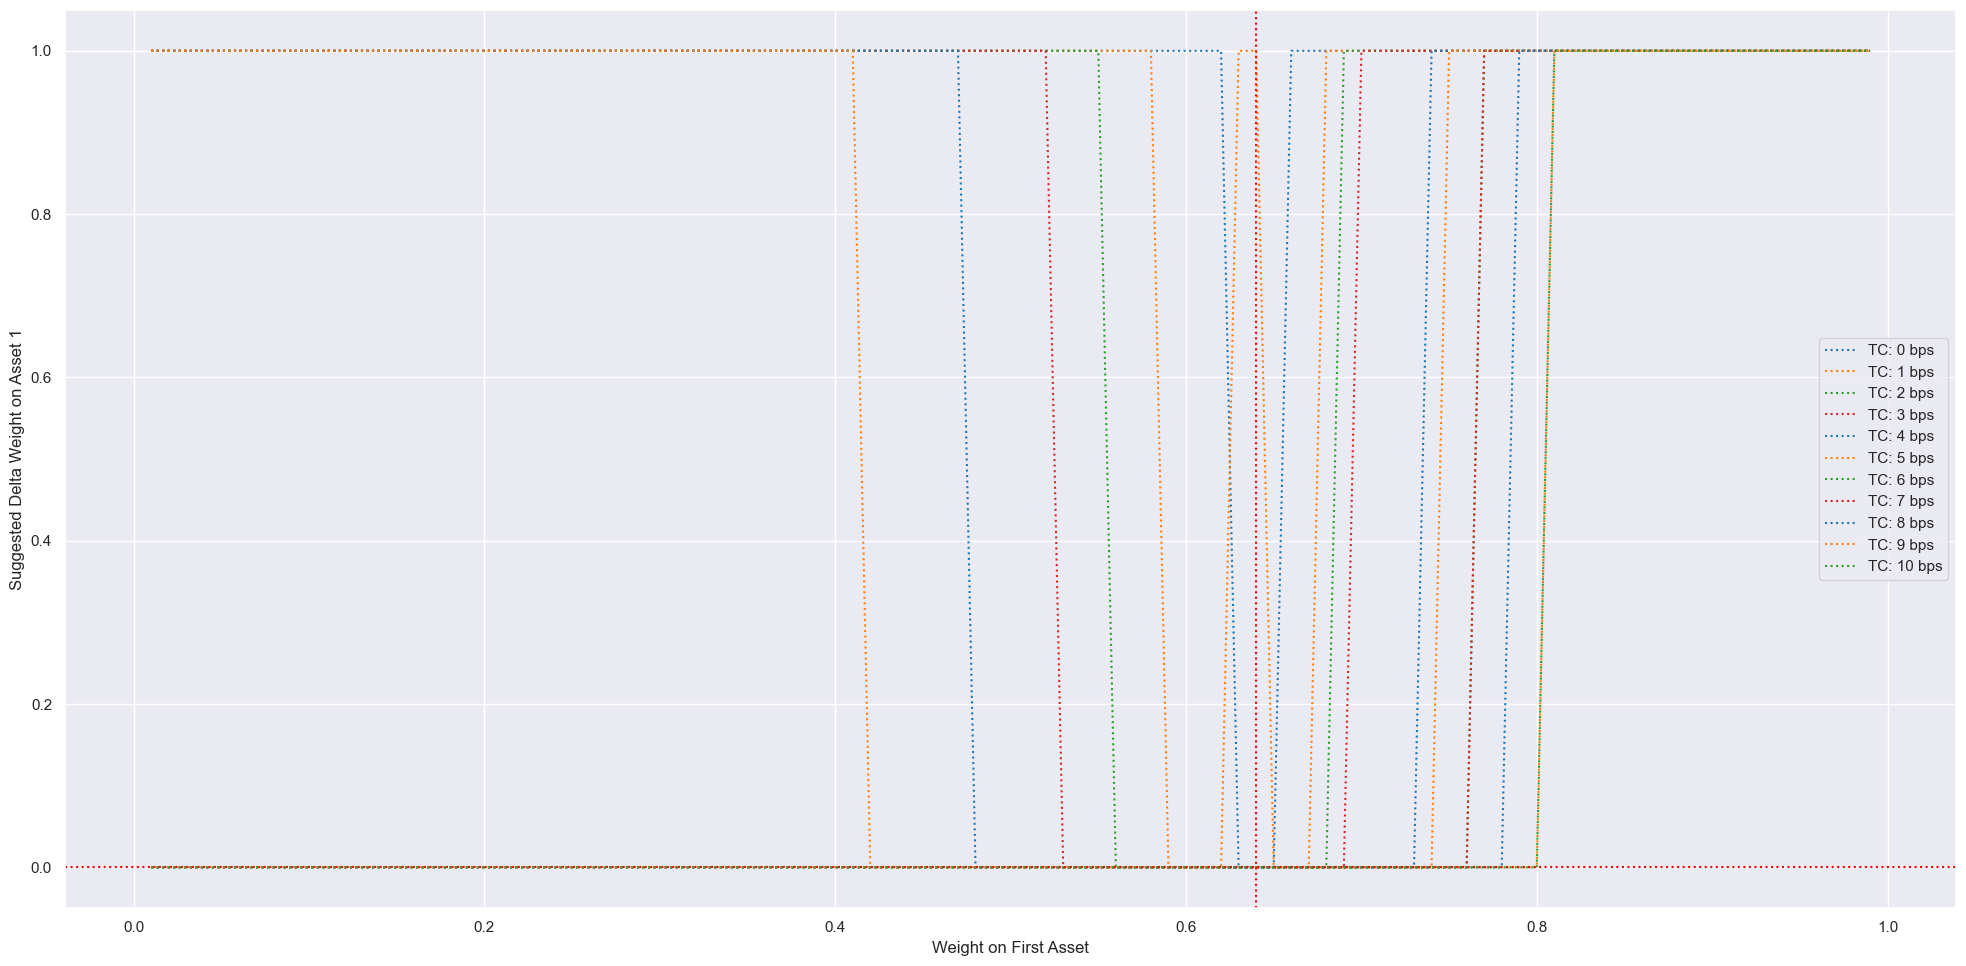

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()

## Visualize Results

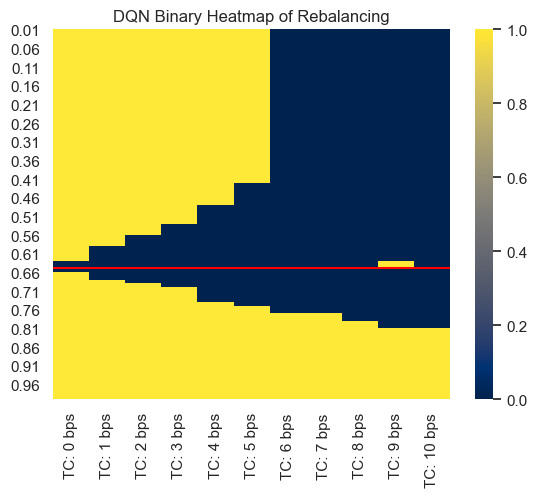

In [28]:
sns.heatmap(dqn_action_df, cmap='cividis')

y = optimal_weight[0]
ax = plt.gca()
plt.hlines(y=y*100, xmin=0, xmax=len(dqn_action_df.columns), colors='red')
plt.title("DQN Binary Heatmap of Rebalancing")
plt.show()

In [29]:
# Assuming `dqn_bool_action_df` and `bool_action_bm_df` are your DataFrames
dqn_df = dqn_action_df.copy()
bm_df = action_df.copy()

# Create a heatmap trace for DQN Binary
trace_dqn = go.Heatmap(z=dqn_df, x=dqn_df.columns, y=dqn_df.index, name="DQN Binary")

# Create a heatmap trace for DP Bellman
trace_dp = go.Heatmap(z=bm_df, x=bm_df.columns, y=bm_df.index, name="DP Bellman")

# Create the layout with 'overlay' parameter set to "overlay"
layout_dqn = go.Layout(
    title="DQN Binary",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Weight on First Asset",
               showgrid=True))

layout_dp = go.Layout(
    title="DP",
    xaxis=dict(title="Transaction Cost (bps)",
               showgrid=True),
    yaxis=dict(title="Weight on First Asset",
               showgrid=True))

# Add horizontal line at y=0.50
layout_dqn.shapes = [
    dict(
        type="line",
        x0=dqn_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=dqn_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]

layout_dp.shapes = [
    dict(
        type="line",
        x0=bm_df.columns[0],  # Adjust x0 to the starting point of your data
        x1=bm_df.columns[-1],  # Adjust x1 to the ending point of your data
        y0=optimal_weight[0],
        y1=optimal_weight[0],
        line=dict(color="red", width=2),  # You can customize the color and width of the line
    )
]

# Create the figures
fig_dqn = go.Figure(data=[trace_dqn], layout=layout_dqn)
fig_dp = go.Figure(data=[trace_dp], layout=layout_dp)

fig_dqn.show()
fig_dp.show()


In [30]:
# Create an empty dataframe to store the confusion matrices
confusion_matrices = {}

# Iterate through the columns and calculate confusion matrices
for col1, col2 in zip(bm_df.columns, dqn_df.columns):
    true_labels = bm_df[col1]
    predicted_labels = dqn_df[col2]

    # Create the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)
    confusion_matrices[col1] = confusion

# Print or use the confusion matrices as needed
for column, confusion in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(confusion)


Confusion Matrix for TC: 0 bps:
[[ 1  0]
 [ 2 96]]
Confusion Matrix for TC: 1 bps:
[[ 5  0]
 [ 4 90]]
Confusion Matrix for TC: 2 bps:
[[10  0]
 [ 3 86]]
Confusion Matrix for TC: 3 bps:
[[15  1]
 [ 2 81]]
Confusion Matrix for TC: 4 bps:
[[22  0]
 [ 4 73]]
Confusion Matrix for TC: 5 bps:
[[32  2]
 [ 1 64]]
Confusion Matrix for TC: 6 bps:
[[74  0]
 [ 2 23]]
Confusion Matrix for TC: 7 bps:
[[76  0]
 [ 0 23]]
Confusion Matrix for TC: 8 bps:
[[77  0]
 [ 1 21]]
Confusion Matrix for TC: 9 bps:
[[76  2]
 [ 2 19]]
Confusion Matrix for TC: 10 bps:
[[80  0]
 [ 0 19]]


In [31]:
dqn_noreb = {}
bm_noreb = {}
for col1, col2 in zip(bm_df.columns, dqn_df.columns):
    bm_index = bm_df[bm_df[col1] == 0].index.values
    dqn_index = dqn_df[dqn_df[col2] == 0].index.values
    bm_noreb[col2] = bm_index
    dqn_noreb[col2] = dqn_index

In [32]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="DQN No Rebalance Zone").update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

# Show the plot
fig.show()

In [33]:
# Create a DataFrame from the dictionary, excluding keys with empty values
df = pd.DataFrame.from_dict(bm_noreb, orient='index').T

# Create a box plot using Plotly
fig = px.box(df, title="DP No Rebalance Zone").update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

# Show the plot
fig.show()

In [34]:
# Create DataFrames from the dictionaries
df_bm = pd.DataFrame.from_dict(bm_noreb, orient='index').T
df_dqn = pd.DataFrame.from_dict(dqn_noreb, orient='index').T

df_dqn['algo'] = ['DQN']*df_dqn.shape[0]
df_bm['algo'] = ['DP']*df_bm.shape[0]

# Merge the two DataFrames
df_merged = pd.concat([df_bm, df_dqn])

# Create a box plot using Plotly
fig = px.box(df_merged, title="No Rebalance Zone", color='algo')\
    .update_layout(yaxis_title="Weight Asset 1", xaxis_title="Transaction Cost")

fig.add_hline(y=optimal_weight[0], opacity=0.5)

# Show the plot
fig.show()